# 1- Hello Friends

Hello Future Engineers, Nice to meet you!

First we import our libraries that will we need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os
import glob as gb
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout
from zipfile import ZipFile
import matplotlib.image as mpimg
import warnings

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

# 2- Prepare Data
Import **train** and **test** data as dataframes by extracting images from zip files and add images names in dataframe.

In [2]:
ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r").extractall()
ZipFile("/kaggle/input/dogs-vs-cats/test1.zip", "r").extractall()

In [3]:
train_path = "./train"
test_path = "./test1"

In [4]:
filenames = os.listdir(train_path)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(category)
    else:
        categories.append(category)

df = pd.DataFrame({
    'Image': filenames,
    'Category': categories})
df.head(-5)

,Image,Category
0,cat.11045.jpg,cat
1,cat.2542.jpg,cat
2,cat.353.jpg,cat
3,dog.4667.jpg,dog
4,dog.2628.jpg,dog
...,...,...
24990,dog.3445.jpg,dog
24991,dog.9739.jpg,dog
24992,dog.10025.jpg,dog
24993,cat.11133.jpg,cat


<AxesSubplot:>

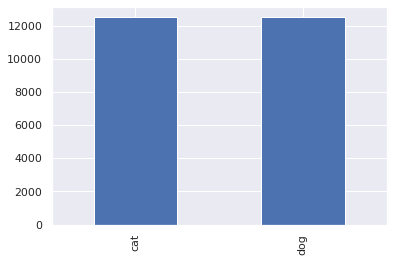

In [5]:
df['Category'].value_counts().plot.bar()

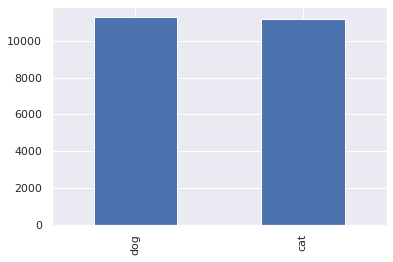

<AxesSubplot:>

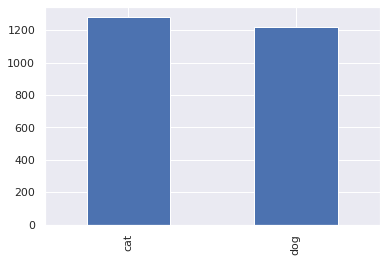

In [6]:
df_train, df_validation = train_test_split(df, test_size=0.1, random_state=18)
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_train['Category'].value_counts().plot.bar()
plt.show()
df_validation['Category'].value_counts().plot.bar()

Let's check our images.

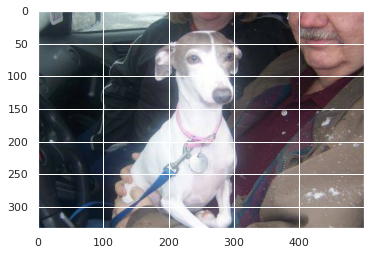

In [7]:
sample = random.choice(df['Image'])
plt.imshow(plt.imread(("./train/"+sample)))

# 3- Setup Variables
Define the size of image and its channel, batch size  and the number of epochs.

In [8]:
size  = 150
channels = 3
batch = 128
epochs = 50

# 4- Data Augmentation
Let's make augmentation on training data and only scaling validation and test data.

In [9]:
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             width_shift_range=.2, height_shift_range=.2,
                             rotation_range=30,
                             brightness_range=[0.8, 1.2],
                             horizontal_flip=True)

datagenValidation = ImageDataGenerator(rescale=1./255)

In [10]:
X_train = datagen.flow_from_dataframe(
    df_train, 
    directory = train_path, 
    x_col = 'Image',
    y_col = 'Category',
    target_size= (size,size),
    class_mode = 'binary',
    shuffle = True,
    batch_size = batch)

X_validation = datagenValidation.flow_from_dataframe(
    df_validation, 
    directory = train_path, 
    x_col = 'Image',
    y_col = 'Category',
    target_size= (size,size),
    class_mode = 'binary',
    shuffle = True,
    batch_size = batch)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


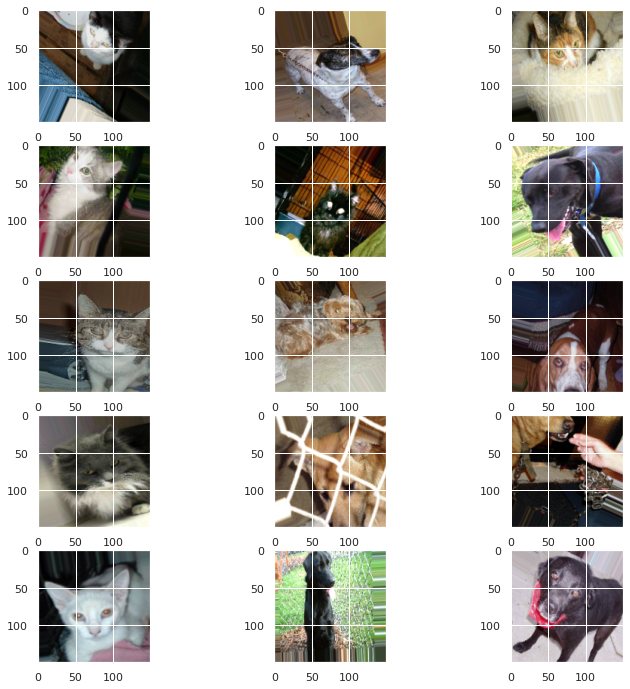

In [11]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in X_train:
        image = X_batch[0]
        plt.imshow(image)
        break
# plt.tight_layout()
plt.show()

# 5- Setup Callbacks

In [12]:
checkpoint_filepath = 'best_model.hdf5'

callback_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callback_learningrate = ReduceLROnPlateau(monitor='val_accuracy', mode='max', min_delta=0.03, patience=3, factor=.5, min_lr=0.00001, verbose=1)

callbacks = [callback_checkpoint, callback_learningrate]

# 6- Design the Neural Network

In [13]:
Model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(size,size,channels)),
                    BatchNormalization(),
                    MaxPool2D(2,2),
                    Dropout(0.2),
                 
                    Conv2D(filters=64,  kernel_size=(5,5), activation="relu"),
                    BatchNormalization(),
                    MaxPool2D(3,3),
                    Dropout(0.2),
                
                    Conv2D(filters=128, kernel_size=(7,7), activation="relu"),
                    BatchNormalization(),
                    MaxPool2D(4,4),
                    Dropout(0.2),
                 
                    Flatten(),
                    
                    Dense(units=4096, activation="relu"),                 
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(units=1024, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    
                                        
                    Dense(units=2, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.5),
                    
                    Dense(units=1, activation="sigmoid"),
])


Model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 70, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 70, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0

# 7- Let's train

In [14]:
history = Model.fit(X_train, validation_data=X_validation, epochs=epochs, callbacks=callbacks)

Epoch 1/50
176/176 [==============================] - 175s 972ms/step - loss: 0.6839 - accuracy: 0.5670 - val_loss: 0.7726 - val_accuracy: 0.5120
Epoch 2/50
176/176 [==============================] - 171s 972ms/step - loss: 0.6314 - accuracy: 0.6314 - val_loss: 0.6741 - val_accuracy: 0.5784
Epoch 3/50
176/176 [==============================] - 173s 982ms/step - loss: 0.6087 - accuracy: 0.6543 - val_loss: 0.8821 - val_accuracy: 0.5352
Epoch 4/50
176/176 [==============================] - 173s 983ms/step - loss: 0.5832 - accuracy: 0.6741 - val_loss: 0.5086 - val_accuracy: 0.7776
Epoch 5/50
176/176 [==============================] - 170s 969ms/step - loss: 0.5572 - accuracy: 0.6980 - val_loss: 0.5055 - val_accuracy: 0.7388
Epoch 6/50
176/176 [==============================] - 171s 971ms/step - loss: 0.5255 - accuracy: 0.7207 - val_loss: 0.4146 - val_accuracy: 0.8296
Epoch 7/50
176/176 [==============================] - 171s 975ms/step - loss: 0.5149 - accuracy: 0.7237 - val_loss: 0.5275 -

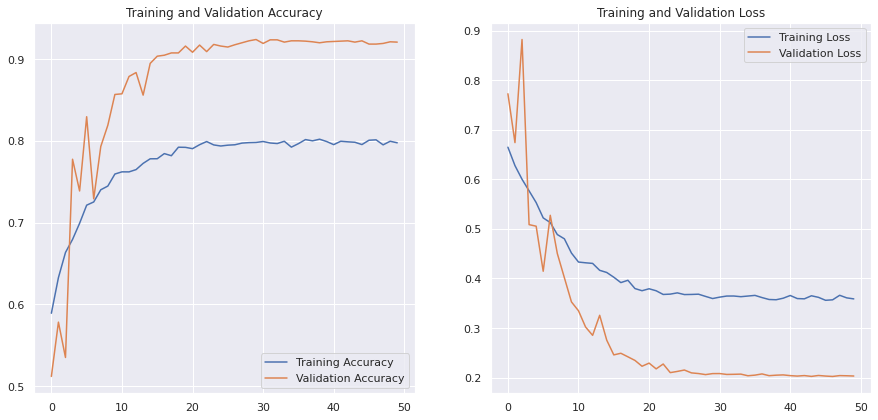

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 8- Let's predict

In [16]:
Model = tf.keras.models.load_model('best_model.hdf5')

In [17]:
filenames = os.listdir(test_path)
df_test = pd.DataFrame({'Image':filenames})

df_test.head(-5)

,Image
0,8405.jpg
1,10506.jpg
2,11692.jpg
3,10165.jpg
4,10053.jpg
...,...
12490,12058.jpg
12491,12329.jpg
12492,10208.jpg
12493,4266.jpg


In [18]:
X_test = datagenValidation.flow_from_dataframe(
    df_test, 
    directory=test_path, 
    x_col='Image',
    y_col=None,
    class_mode=None,
    target_size= (size,size),
    batch_size=batch,
    shuffle=False
)

Found 12500 validated image filenames.


In [19]:
X_train.class_indices

{'cat': 0, 'dog': 1}

In [20]:
y_pred = Model.predict(X_test)

In [21]:
y_pred = np.where(y_pred > .5, "Dog", "Cat")
y_pred

array([['Cat'],
       ['Cat'],
       ['Cat'],
       ...,
       ['Cat'],
       ['Dog'],
       ['Dog']], dtype='<U3')

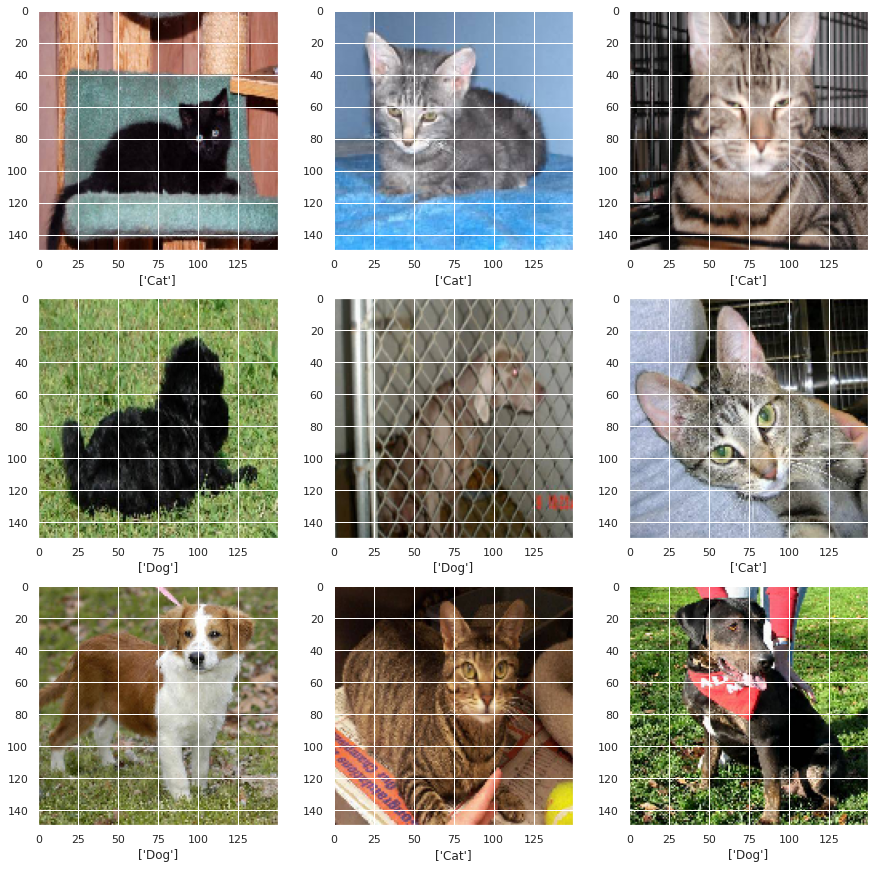

In [22]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[0][i])
    plt.xlabel(y_pred[i])
    
plt.show()

In [23]:
label = np.where(y_pred=="Cat", 0, 1)
label

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

# 9- Let's submit

In [24]:
df_submission = pd.read_csv('../input/dogs-vs-cats/sampleSubmission.csv')
df_submission['label'] = label
df_submission.head(-5)

,id,label
0,1,0
1,2,0
2,3,0
3,4,1
4,5,1
...,...,...
12490,12491,0
12491,12492,1
12492,12493,1
12493,12494,0


In [25]:
df_submission.to_csv('submission.csv', index=False)

In [26]:
submission = pd.read_csv('./submission.csv')
submission.head(-5)

,id,label
0,1,0
1,2,0
2,3,0
3,4,1
4,5,1
...,...,...
12490,12491,0
12491,12492,1
12492,12493,1
12493,12494,0
